## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from numba import jit, prange
from pyccel.epyccel import epyccel
from pyccel.decorators import types
import subprocess
import os
import shutil
import sys
import re
import pytest

## Pure python function

In [5]:
def solve_1d_nonlinearconv_pure(u, un, nt, nx, dt, dx):

    L=dt/dx
    for j in range(nt):
        un=u.copy()
        for i in range(1,nx): 
           un[i]=un[i] + L*un[i]*(un[i]-un[i-1])  # OR with i+1 !
    return 0
 

## Numba accelerator

In [13]:
@jit(fastmath=True,parallel=True)
def solve_1d_nonlinearconv_numba(u, un, nt, nx, dt, dx):

    L=dt/dx
    for j in prange(nt):
        un=u.copy()
        for i in prange(1,nx): 
           un[i]=un[i] + L*un[i]*(un[i]-un[i-1])  
    
    return 0

## Pyccel accelerator

In [24]:
@types('float[:]', 'float[:]','int','int','float','float')

def solve_1d_nonlinearconv_pyccel(u, un, nt, nx, dt, dx):
    L=dt/dx
    for j in range(nt):
        un[:]=u[:]
        for i in range(1,nx): 
           un[i]=un[i] + L*un[i]*(un[i]-un[i-1])  
   
    return 0

## Inputs

Text(0.5, 1.0, '1D Linear Convection')

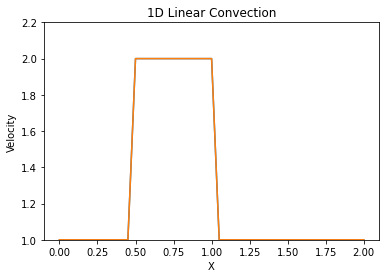

In [25]:
nx = 41  # try changing this number from 41 to 81 and Run All ... what happens?
dx = 2 / (nx-1)
nt = 10    #nt is the number of timesteps we want to calculate
dt = 0.001
grid = np.linspace(0,2,nx) # creating the space grid    

u0 = np.ones(nx)      #numpy function ones()
u0[int(.5 / dx):int(1 / dx + 1)] = 2  #setting u = 2 between 0.5 and 1 as per our I.C.s
plt.plot(grid,u0)
u = u0.copy()
un = np.ones(nx)

solve_1d_nonlinearconv_pure(u, un, nt, nx, dt, dx)
#Plotting data
plt.plot(grid,u);
plt.ylim([1.,2.2])
plt.xlabel('X')
plt.ylabel('Velocity')    
plt.title('1D Linear Convection')

## Call Funtions

### Pure function

In [26]:
%timeit solve_1d_nonlinearconv_pure(u, un, nt, nx, dt, dx)

350 µs ± 12.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Function with numba accelerator

In [27]:
%timeit solve_1d_nonlinearconv_numba(u, un, nt, nx, dt, dx)

4.06 µs ± 561 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Function with pyccel accelerator

In [28]:
solve_1d_nonlinearconv_f90 = epyccel(solve_1d_nonlinearconv_pyccel)

In [29]:
%timeit solve_1d_nonlinearconv_f90(u, un, nt, nx, dt, dx)

1.34 µs ± 3.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
